# Deep Learning - Truck Detection For U-NET model

## 1. Introduction
Deep neural networks are used mainly for supervised learning: classification or regression and segmentation. Thus, we want to build a baseline deep learning model for our project which is the Truck Segmentation. 
- This baseline includes all the steps of a deep learning project
<img src="model.png" style="width: 800px;">

## 2. Dataset 

### Supervised Segmentation Problem Dataset
There are two parts of a supervised segmentation problem dataset.

- Original Image 
- Mask Images 
<img src="ship_img_cut.png" style="width: 800px;">

### Introduction to the reference dataset
To test the baseline and the implementation of U-Net model, we have borrowed the dataset from https://www.kaggle.com/c/tgs-salt-identification-challenge
- Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.<br>
- But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. 
- More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.
- To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#Append the directory to your python path using sys:

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=2ec20cf9bf425b1f16cdf46254c218199315533b57e30c7bc41673f146bd509e
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


# **GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


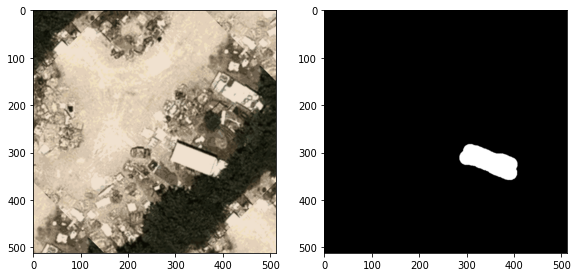

In [ ]:
ids= ['100_TD_r45']
show_sample(ids,train_path_images,train_path_masks)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import sys
import random
from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
from dataset import TruckDataset
from utils import list_ids,train_ds,shuffle,normalize_reshape,show_sample
import matplotlib.pyplot as plt
from model import Unet

In [ ]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'drive/MyDrive/train_dataset_1'
#path_test = 'drive/MyDrivetest_dataset/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

#test_path_images = os.path.abspath(path_test + "/images/")
#test_path_masks = os.path.abspath(path_test + "/masks/")


In [ ]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
#test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
#test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

In [ ]:
train_ids = list_ids(train_path_images)
X_train, Y_train = train_ds(path_train,train_ids,im_height = 128,im_width = 128,im_chan=1)

Getting and resizing train images and masks ... 



Done!


In [ ]:
len(train_ids)

3536

In [ ]:
len(X_train)
len(Y_train)
X_train

In [ ]:
X_train_shaped, Y_train_shaped = normalize_reshape(X_train, Y_train)
train_idxs, val_idxs = shuffle(X_train_shaped, val_size = 0.1)
truck_ID_dataset_train = TruckDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
truck_ID_dataset_val = TruckDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

## 3. Defining The Model
### 3.1. Choosing the model - U-Net Model
After researching some deep learning models for Segmentation Problem, we find that U-Net is a good model to use and easy to implement. Also, from U-Net, we can optimize and generate better Deep Learning model later such as Residual U-Net! 
<img src="u-net.png" style="width: 800px;">

In [ ]:
model = Unet()
model

### 3.2 Defining the Loss Function and Optimizer, Metric
#### Loss Function - Binary Cross Entropy 
- Because are training a binary segmentation problem, we want to use binary cross-entropy / log loss as our loss function.
![log_loss.png](attachment:log_loss.png)

#### Optimizer - Adam
Also, we choose Adam as our optimizer due to its efficiency 

#### Metric - Intersection-Over-Union (IOU)
![metric.png](attachment:metric.png)

### 3.3 Training The Model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

In [ ]:
model = Unet().to(device)
criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3
epoches = 50
threshold = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mean_train_losses = []
mean_val_losses = []
mean_accuracies = []
for epoch in range(epoches):
    train_losses = []
    val_losses = []
    accuracies = []
    ious = []
    for images, masks in train_loader:        
        images = Variable(images).to(device)
        masks = Variable(masks).to(device)
        
        outputs = model(images)  
        output_acc = torch.sigmoid(outputs)
        output_acc = output_acc.cpu().data.numpy()
        output_acc = (output_acc > threshold).astype(int)
        iou = jaccard_score(masks.flatten().cpu().numpy(), output_acc.flatten())
        ious.append(iou)
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images).to(device)
        masks = Variable(masks).to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    temp_1 = torch.mean(torch.stack(train_losses))
    #mean_train_losses.append(np.mean(train_losses))
    mean_train_losses.append(temp_1)
    accuracies = [np.mean(ious > iou_threshold)
                     for iou_threshold in np.linspace(0.5,0.95,10)]
    mean_accuracies.append(np.mean(accuracies))    
    #mean_val_losses.append(np.mean(val_losses))
    temp_2 = torch.mean(torch.stack(val_losses))
    mean_val_losses.append(temp_2)

    # Print Loss
    #print('Epoch: {}. Train Loss: {}. Val Loss: {}. IOU Metric: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses),np.mean(accuracies)))
    print('Epoch: {}. Train Loss: {}. Val Loss: {}. IOU Metric: {}'.format(epoch+1, temp_1, temp_2,np.mean(accuracies)))

Epoch: 1. Train Loss: 0.44926512241363525. Val Loss: 0.32537999749183655. IOU Metric: 0.011055276381909548
Epoch: 2. Train Loss: 0.2635929584503174. Val Loss: 0.24806687235832214. IOU Metric: 0.022110552763819093
Epoch: 3. Train Loss: 0.22517216205596924. Val Loss: 0.22502663731575012. IOU Metric: 0.035678391959799
Epoch: 4. Train Loss: 0.19859835505485535. Val Loss: 0.22050511837005615. IOU Metric: 0.02914572864321608
Epoch: 5. Train Loss: 0.17553511261940002. Val Loss: 0.1735159307718277. IOU Metric: 0.07035175879396985
Epoch: 6. Train Loss: 0.14731080830097198. Val Loss: 0.14122256636619568. IOU Metric: 0.13969849246231153
Epoch: 7. Train Loss: 0.13325121998786926. Val Loss: 0.13707688450813293. IOU Metric: 0.21809045226130652
Epoch: 8. Train Loss: 0.13513152301311493. Val Loss: 0.1375737339258194. IOU Metric: 0.18743718592964825
Epoch: 9. Train Loss: 0.12843631207942963. Val Loss: 0.11475787311792374. IOU Metric: 0.22110552763819094
Epoch: 10. Train Loss: 0.10336635261774063. Val L

Text(0.5, 1.0, 'Relationship between training loss and validation loss')

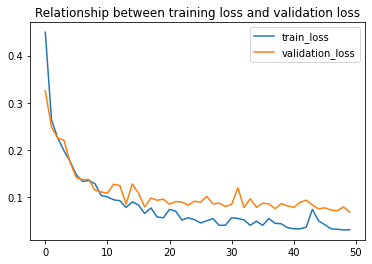

In [ ]:
#convert tensor to numpy:
mean_train_losses_numpy = []
mean_val_losses_numpy = []
#

for element in mean_train_losses:
  mean_train_losses_numpy.append(element.item())
for element in mean_val_losses:
  mean_val_losses_numpy.append(element.item())

train_loss_series = pd.Series(mean_train_losses_numpy)
train_accuracy_series = pd.Series(mean_accuracies)
val_loss_series = pd.Series(mean_val_losses_numpy)

train_loss_series.plot(label="train_loss")
val_loss_series.plot(label="validation_loss")
plt.legend()
plt.title("Relationship between training loss and validation loss")

Text(0.5, 1.0, 'Training Accuracy')

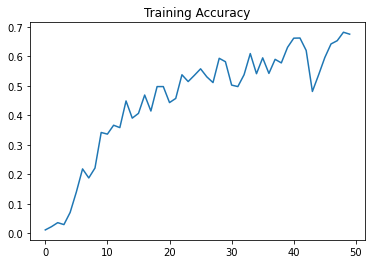

In [ ]:
train_accuracy_series.plot(label="train_accuracy")
plt.title("Training Accuracy")

## 4. Evaluate The Model

In [ ]:
y_pred_true_pairs = []
for images, masks in val_loader:
  #
    images = Variable(images).to(device)
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))


In [ ]:
y_pred = y_preds[0] 
y_pred = torch.sigmoid(y_pred)
y_pred = y_pred.cpu().data.numpy()
y_pred

array([[[6.7379582e-04, 5.4586737e-04, 5.7672447e-04, ...,
         6.6020155e-05, 7.4656760e-05, 1.5668610e-04],
        [3.9443839e-04, 2.6694476e-04, 2.6708221e-04, ...,
         2.5073603e-05, 2.6367772e-05, 8.1192709e-05],
        [3.2078690e-04, 2.4631646e-04, 2.9116872e-04, ...,
         3.7072092e-05, 3.0021620e-05, 7.4675772e-05],
        ...,
        [1.8002246e-02, 1.5348455e-02, 2.3288680e-02, ...,
         3.8221449e-04, 5.8507919e-04, 1.1896017e-03],
        [1.4747850e-02, 1.8195944e-02, 2.9405370e-02, ...,
         7.3133886e-04, 6.3265406e-04, 1.1480711e-03],
        [8.8904519e-03, 1.1727809e-02, 1.9034203e-02, ...,
         7.6778687e-04, 6.3332968e-04, 1.1296656e-03]]], dtype=float32)

[[[0.5019608  0.5411765  0.5568628  ... 0.46666667 0.47058824 0.41960785]
  [0.5764706  0.62352943 0.6313726  ... 0.5294118  0.52156866 0.4745098 ]
  [0.5686275  0.6039216  0.6156863  ... 0.52156866 0.52156866 0.4745098 ]
  ...
  [0.6156863  0.6313726  0.4117647  ... 0.59607846 0.54901963 0.45490196]
  [0.6117647  0.67058825 0.42745098 ... 0.6        0.5764706  0.4862745 ]
  [0.59607846 0.6392157  0.46666667 ... 0.54509807 0.5372549  0.4745098 ]]]


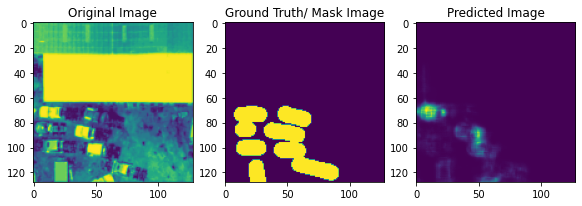

In [ ]:

plt.figure(figsize=(20,10))
plt.subplot(1,2*(1+2),2*2-1)
#
print(images[0].cpu().detach().numpy() )
x = images[0].cpu().detach().numpy()
plt.imshow(np.reshape(x,(128,128)))
plt.title("Original Image")
plt.subplot(1,2*(1+2),2*2)
plt.title("Ground Truth/ Mask Image")
plt.imshow(np.reshape(masks[0],(128,128)))
plt.subplot(1,2*(1+2),2*2+1)
plt.title("Predicted Image")
#
plt.imshow(np.reshape(y_pred,(128,128)))
plt.show()

## **Saving and loading networks**
As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layers.


In [ ]:

print("The state dict keys: \n\n", model.state_dict().keys())

The state dict keys: 

 odict_keys(['double_conv1.conv.0.weight', 'double_conv1.conv.0.bias', 'double_conv1.conv.1.weight', 'double_conv1.conv.1.bias', 'double_conv1.conv.1.running_mean', 'double_conv1.conv.1.running_var', 'double_conv1.conv.1.num_batches_tracked', 'double_conv1.conv.3.weight', 'double_conv1.conv.3.bias', 'double_conv1.conv.4.weight', 'double_conv1.conv.4.bias', 'double_conv1.conv.4.running_mean', 'double_conv1.conv.4.running_var', 'double_conv1.conv.4.num_batches_tracked', 'double_conv2.conv.0.weight', 'double_conv2.conv.0.bias', 'double_conv2.conv.1.weight', 'double_conv2.conv.1.bias', 'double_conv2.conv.1.running_mean', 'double_conv2.conv.1.running_var', 'double_conv2.conv.1.num_batches_tracked', 'double_conv2.conv.3.weight', 'double_conv2.conv.3.bias', 'double_conv2.conv.4.weight', 'double_conv2.conv.4.bias', 'double_conv2.conv.4.running_mean', 'double_conv2.conv.4.running_var', 'double_conv2.conv.4.num_batches_tracked', 'double_conv3.conv.0.weight', 'double_conv3.

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')
# reference: https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%206%20-%20Saving%20and%20Loading%20Models.ipynb#scrollTo=5_Md8rtVpCYE


In [ ]:
checkpoint = {
              'state_dict': model.state_dict(),
              'train_ids' : train_ids,
              'X_train'   : X_train,
              'Y_train'   : Y_train}

torch.save(checkpoint, 'checkpoint.pth')

# **save and load the state of the kernel**

In [ ]:
import dill
dill.dump_session('drive/MyDrive/Colab Notebooks/notebook_env_1.db')

In [ ]:
import dill
dill.load_session('drive/MyDrive/Colab Notebooks/notebook_env_1.db')